El conjunto de datos de vivienda de Boston

El conjunto de datos de vivienda de Boston se deriva de la información recopilada por el Servicio del Censo de EE. UU. sobre viviendas en el área de Boston MA. A continuación se describen las columnas del conjunto de datos:

CRIM - tasa de criminalidad per cápita por ciudad
ZN: proporción de suelo residencial zonificado para lotes de más de 25.000 pies cuadrados.
INDUS: proporción de acres de negocios no minoristas por ciudad.
CHAS - Variable ficticia de Charles River (1 si el tramo limita con el río; 0 en caso contrario)
NOX - concentración de óxidos nítricos (partes por 10 millones)
RM - número medio de habitaciones por vivienda
EDAD: proporción de unidades ocupadas por sus propietarios construidas antes de 1940
DIS: distancias ponderadas a cinco centros de empleo de Boston
RAD - índice de accesibilidad a carreteras radiales
IMPUESTO: tasa de impuesto a la propiedad de valor total por $10,000
PTRATIO - ratio alumnos-maestro por ciudad
B - 1000(Bk - 0,63)^2 donde Bk es la proporción de negros por ciudad
LSTAT - % de estatus inferior de la población
MEDV - Valor medio de viviendas ocupadas por sus propietarios en miles de dólares

In [11]:
%config IPCompleter.greedy=True
import pandas as pd
import numpy as np
import xlrd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


In [12]:
from google.colab import files
files.upload()
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# reading a excel file using pandas library
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

df = pd.DataFrame(pd.np.empty((0, 7)))
df = pd.read_excel('Boston_housing.xlsx',names=column_names)
df.dtypes
df.head()







Saving Boston_housing.xlsx to Boston_housing (2).xlsx


<ipython-input-12-c60e6cc2b6b3>:10: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df = pd.DataFrame(pd.np.empty((0, 7)))


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.02731,0.0,7070.0,0,0.469,64210,78.9,49671,2,242.0,17.8,396.90,9.14,21.6
1,0.02729,0.0,7070.0,0,0.469,71850,61.1,49671,2,242.0,17.8,392.83,4.03,34.7
2,0.03237,0.0,2180.0,0,0.458,69980,45.8,60622,3,222.0,18.7,394.63,2.94,33.4
3,0.06905,0.0,2180.0,0,0.458,71470,54.2,60622,3,222.0,18.7,396.90,5.33,36.2
4,0.02985,0.0,2180.0,0,0.458,64300,58.7,60622,3,222.0,18.7,394.12,5.21,28.7


In [13]:
# Dimensión del dataset
print(np.shape(df))

(505, 14)


In [14]:
# Resumamos el dataset para ver la distribución de variables
print(df.describe())

               CRIM          ZN         INDUS        CHAS         NOX  \
count  5.050000e+02  505.000000    505.000000  505.000000  505.000000   
mean   3.493430e+05   11.350495  11151.883564    0.069307    0.554728   
std    8.658028e+05   23.343704   6859.626903    0.254227    0.115990   
min    9.060000e-03    0.000000      0.460000    0.000000    0.385000   
25%    8.221000e-02    0.000000   5190.000000    0.000000    0.449000   
50%    2.591500e-01    0.000000   9690.000000    0.000000    0.538000   
75%    3.678220e+05   12.500000  18100.000000    0.000000    0.624000   
max    8.897620e+06  100.000000  27740.000000    1.000000    0.871000   

                 RM         AGE            DIS         RAD         TAX  \
count    505.000000  505.000000     505.000000  505.000000  505.000000   
mean   62840.594059   68.581584   37944.586139    9.566337  408.459406   
std     7031.946662   28.176371   21077.570605    8.707553  168.629992   
min    35610.000000    2.900000   11296.000000

Desde el principio, dos columnas de datos muestran resúmenes interesantes. Son: ZN (proporción de suelo residencial zonificado para lotes de más de 25.000 pies cuadrados) con 0 para los percentiles 25 y 50. En segundo lugar, CHAS: variable ficticia de Charles River (1 si el tramo limita con el río; 0 en caso contrario) con 0 para los percentiles 25, 50 y 75. Estos resúmenes son comprensibles ya que ambas variables son variables condicionales + categóricas. La primera suposición sería que estos canales pueden no ser útiles en tareas de regresión como la predicción del MEDV (valor medio de las viviendas ocupadas por sus propietarios).

Otro dato interesante sobre el conjunto de datos es el valor máximo de MEDV. De la descripción de los datos originales, dice: La variable #14 parece estar censurada en 50,00 (correspondiente a un precio medio de 50.000 dólares). En base a esto, es posible que los valores superiores a 50,00 no ayuden a predecir el MEDV. Tracemos el conjunto de datos y veamos tendencias/estadísticas interesantes.

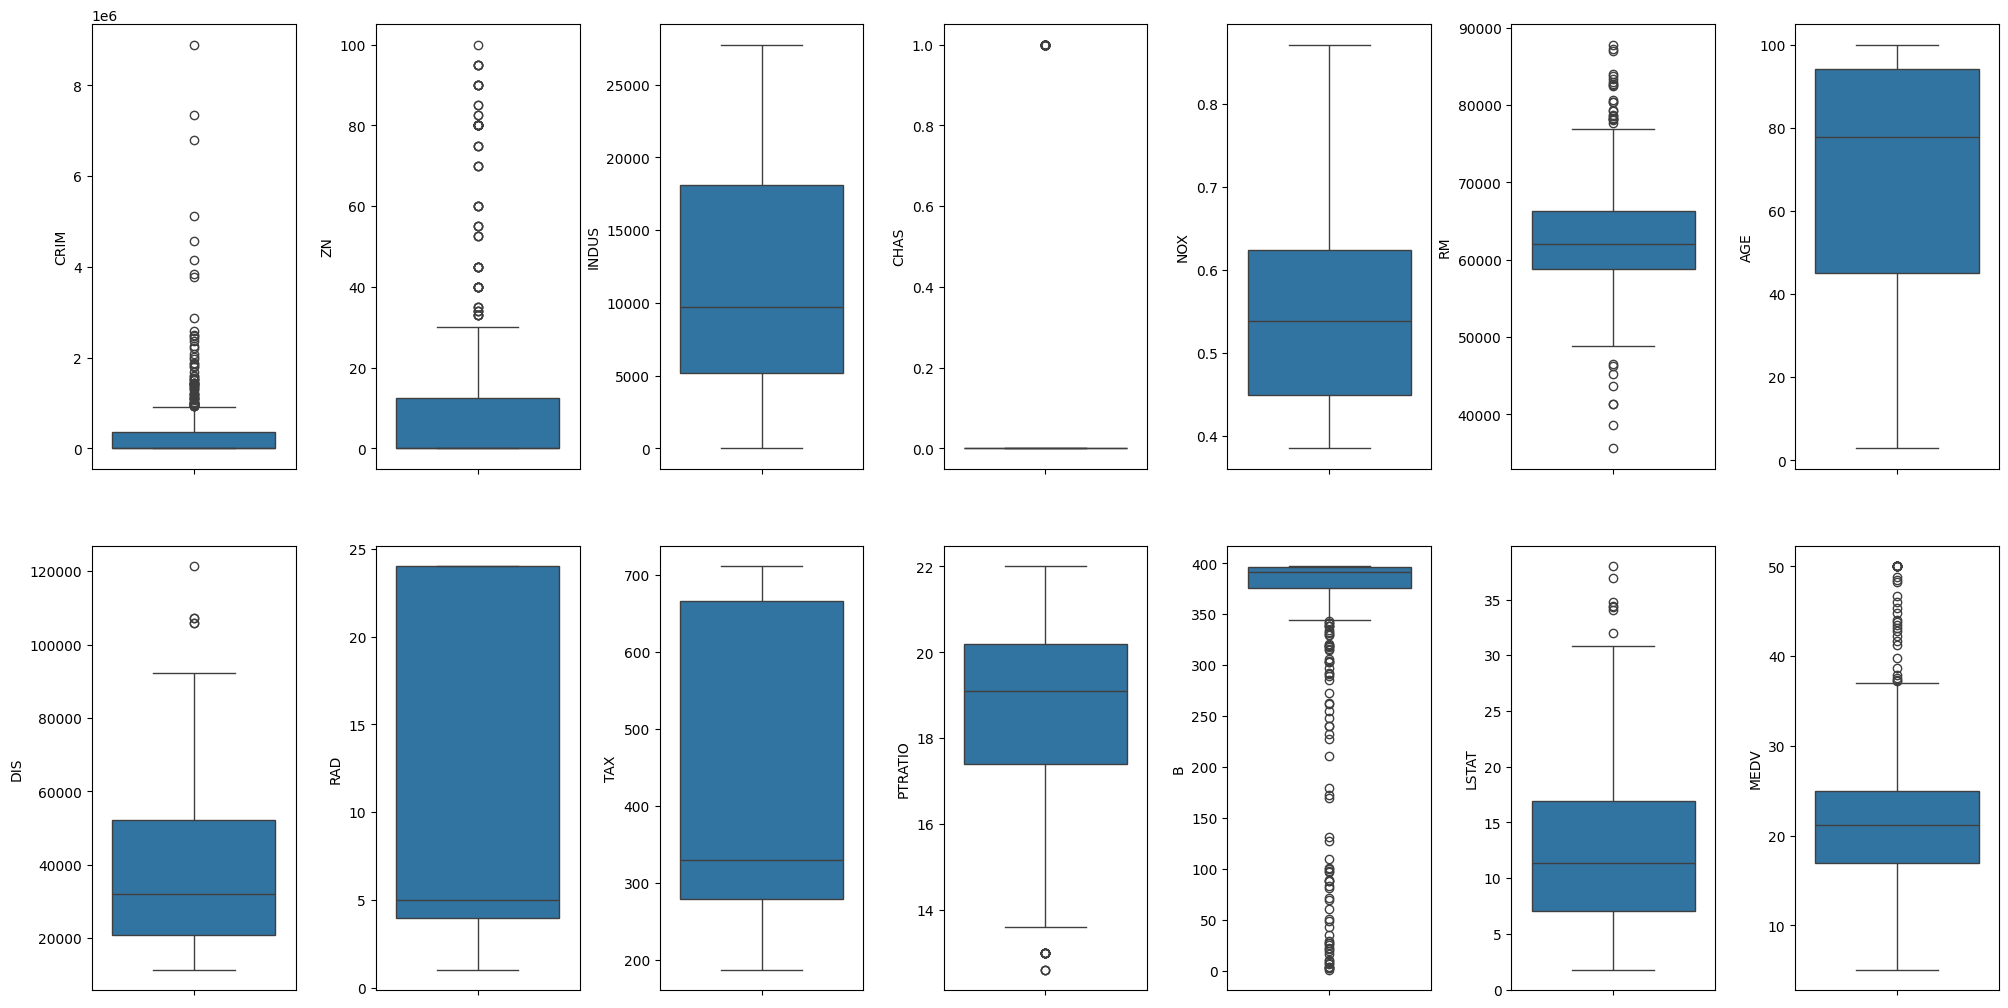

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Columnas como CRIM, ZN, RM, B parecen tener valores atípicos. Veamos el porcentaje de valores atípicos en cada columna.

In [16]:
for k, v in df.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column CRIM outliers = 12.87%
Column ZN outliers = 13.47%
Column INDUS outliers = 0.00%
Column CHAS outliers = 100.00%
Column NOX outliers = 0.00%
Column RM outliers = 5.94%
Column AGE outliers = 0.00%
Column DIS outliers = 0.99%
Column RAD outliers = 0.00%
Column TAX outliers = 0.00%
Column PTRATIO outliers = 2.97%
Column B outliers = 15.05%
Column LSTAT outliers = 1.39%
Column MEDV outliers = 7.92%


Eliminemos los valores atípicos de MEDV (MEDV = 50,0) antes de trazar más distribuciones.

In [18]:
df = df[~(df['MEDV'] >= 50.0)]
print(np.shape(df))

(489, 14)


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2125: UserWarning: `displot` is a figur

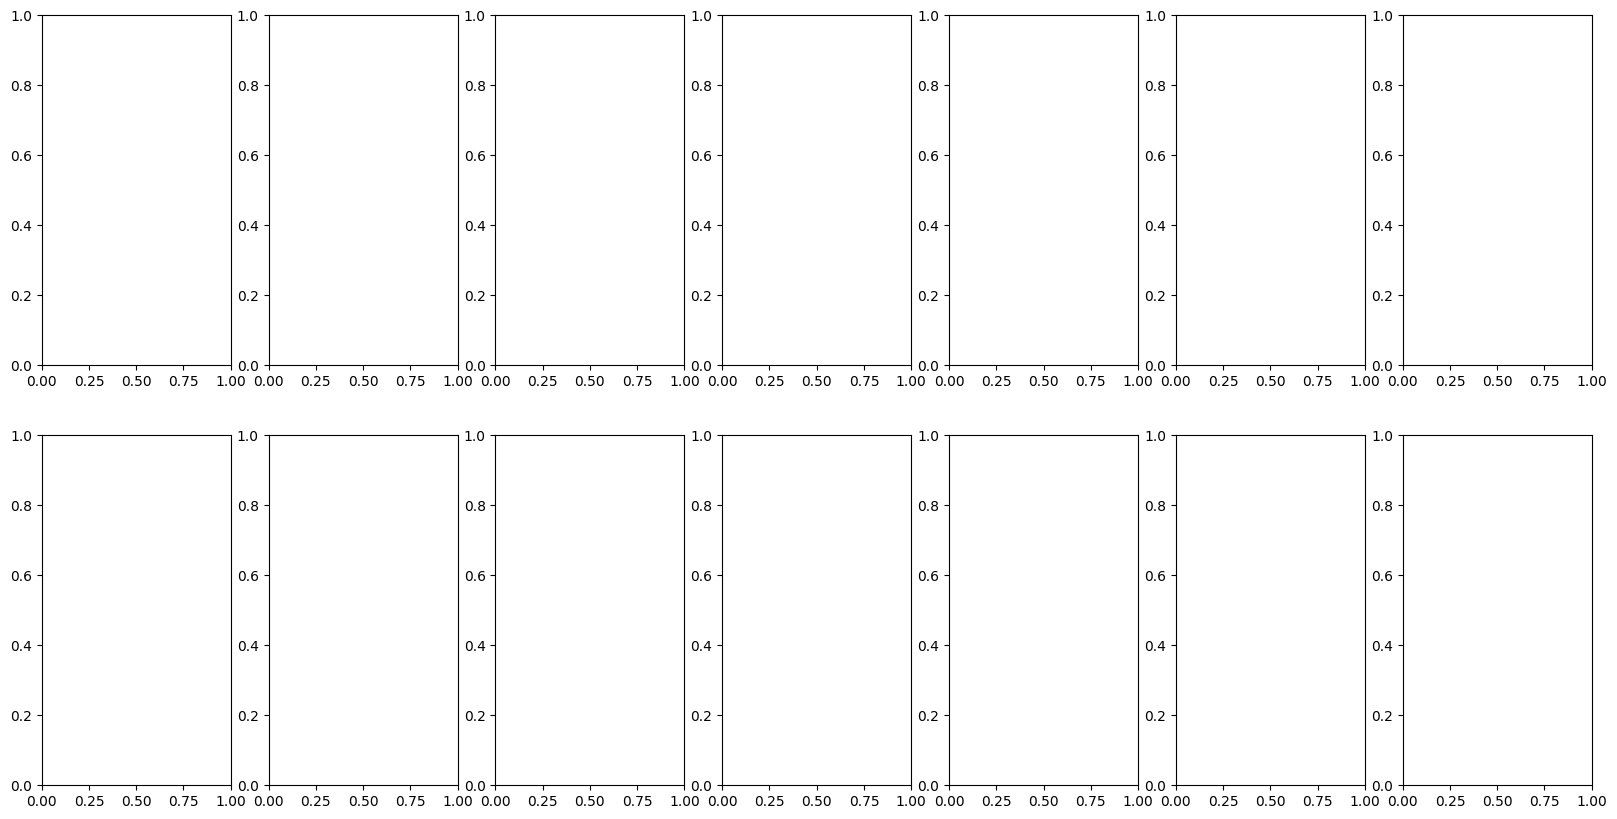

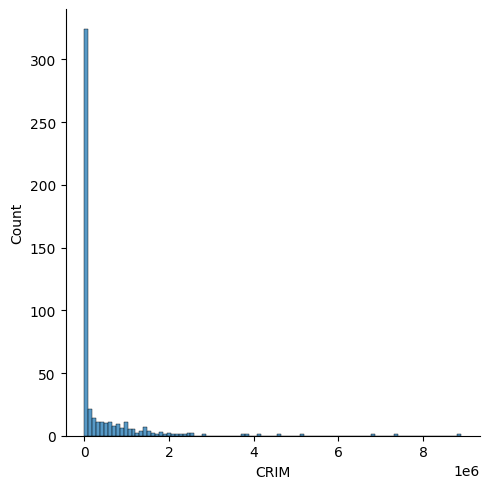

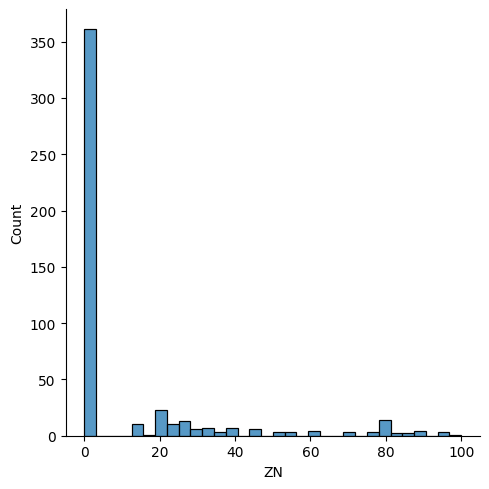

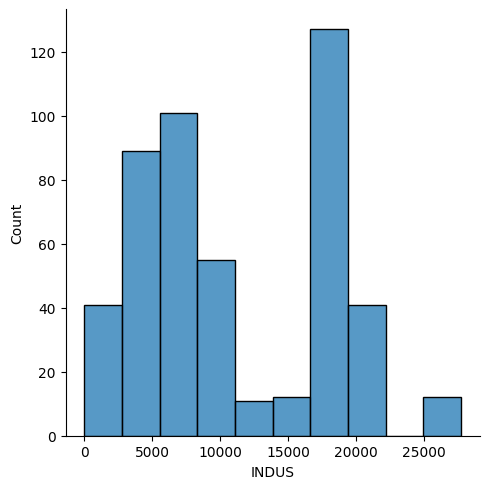

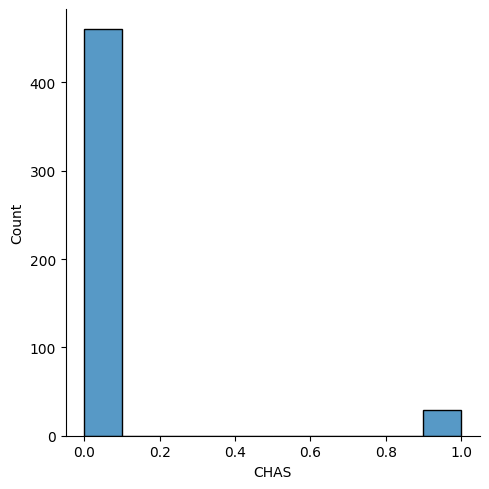

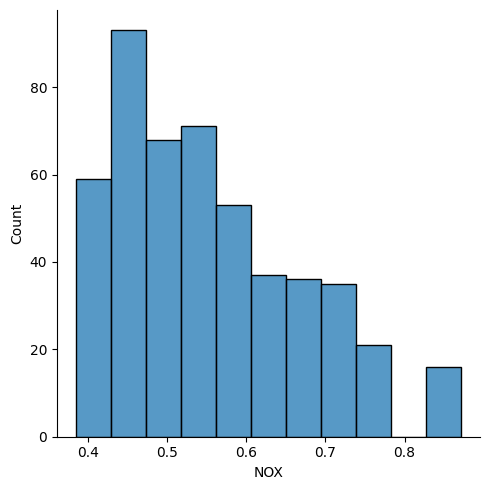

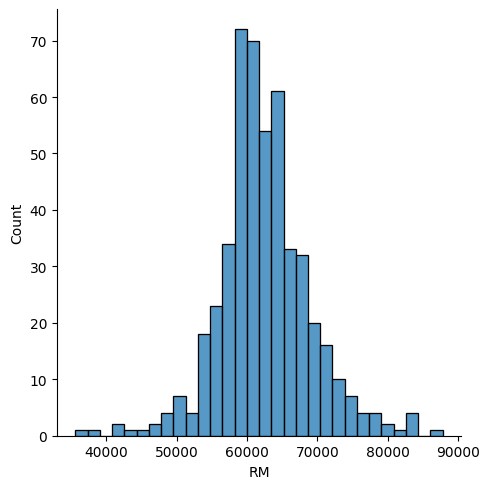

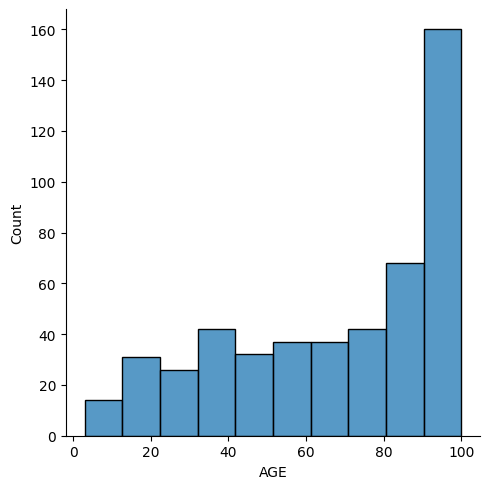

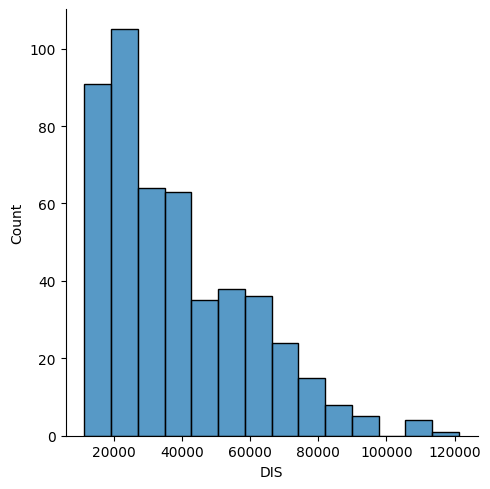

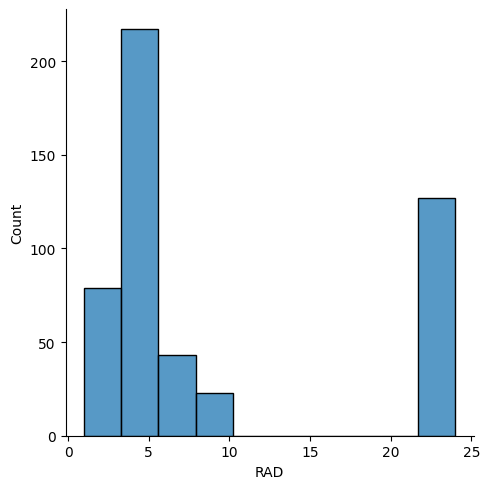

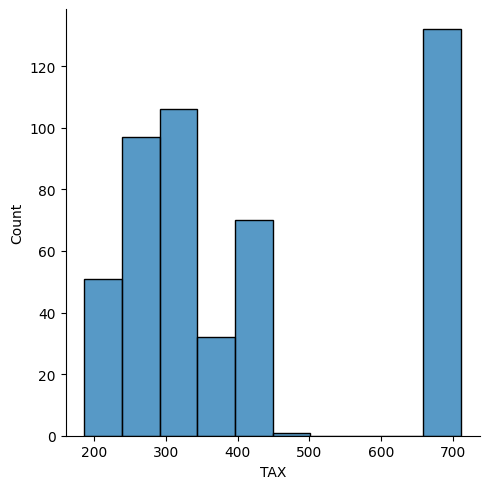

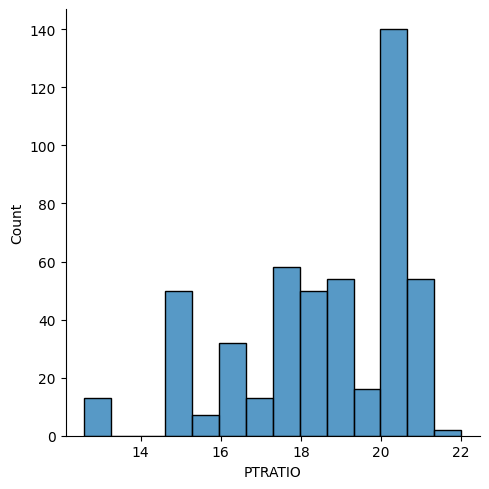

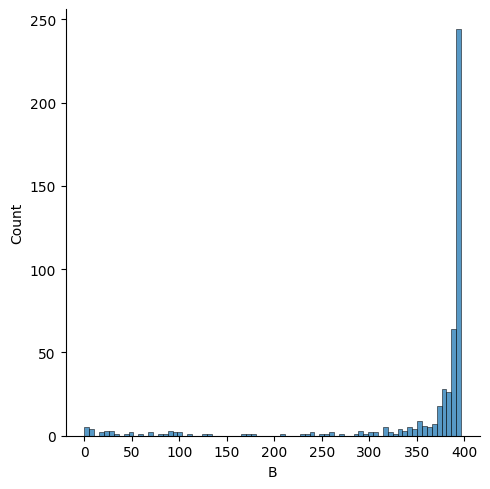

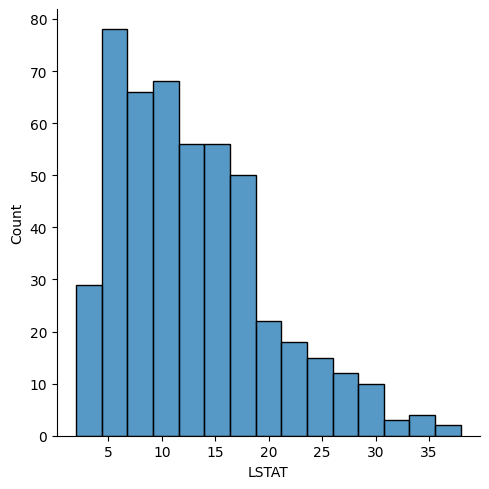

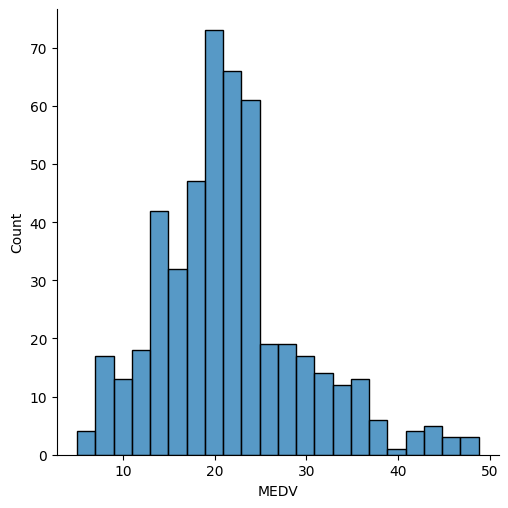

In [21]:
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.displot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

El histograma también muestra que las columnas CRIM, ZN, B tienen distribuciones muy sesgadas. Además, MEDV parece tener una distribución normal (las predicciones) y otras columnas parecen tener una distribución de datos normal o bimodelo, excepto CHAS (que es una variable discreta).

Ahora tracemos la correlación por pares de los datos.

<Axes: >

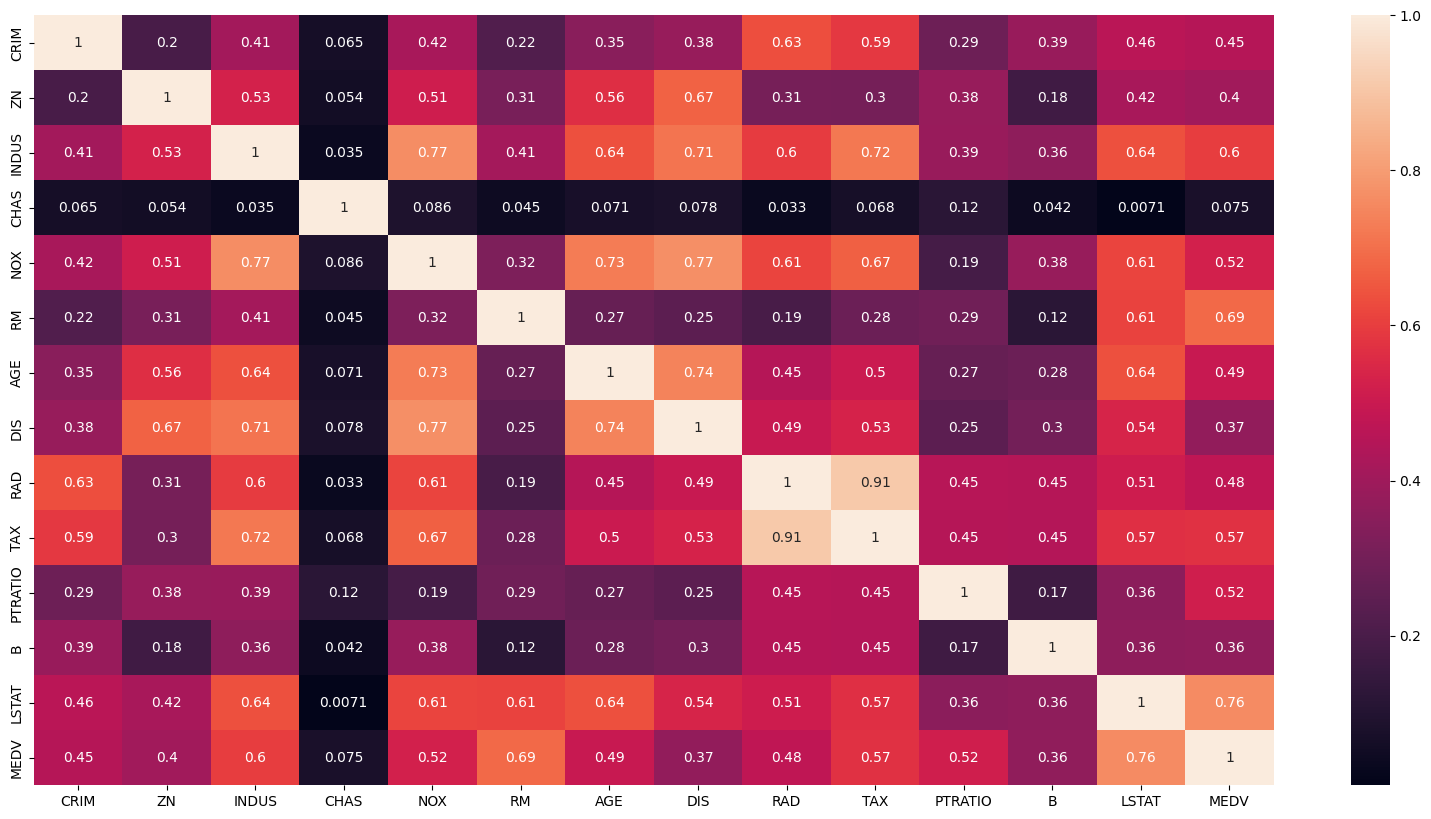

In [22]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr().abs(),  annot=True)

De la matriz de correlación, vemos que TAX y RAD son características altamente correlacionadas. Las columnas LSTAT, INDUS, RM, TAX, NOX, PTRAIO tienen una puntuación de correlación superior a 0,5 con MEDV, lo que es una buena indicación de su uso como predictores. Tracemos estas columnas contra MEDV.

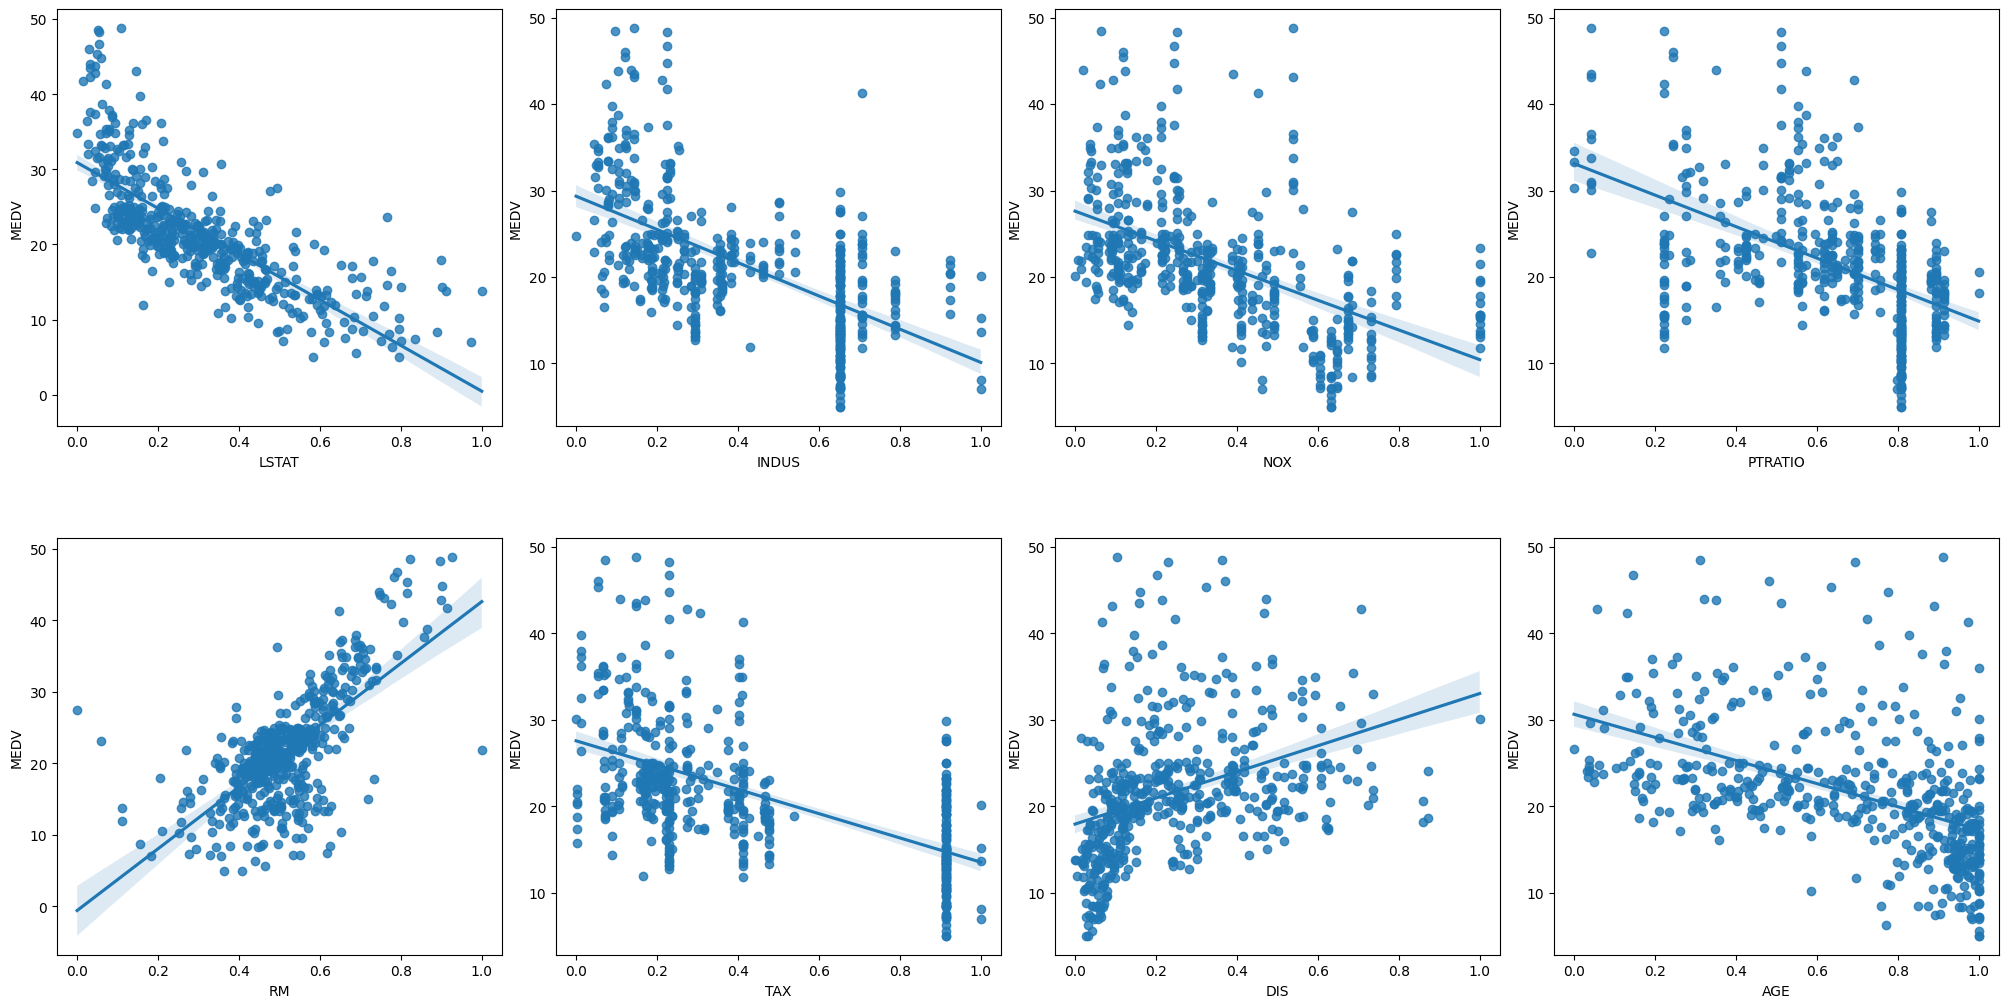

In [23]:
from sklearn import preprocessing
# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = df.loc[:,column_sels]
y = df['MEDV']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Entonces, con estos análisis, podemos intentar predecir MEDV con las características 'LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE'. Intentemos eliminar la asimetría de los datos mediante la transformación del registro.

In [24]:
y =  np.log1p(y)
for col in x.columns:
    if np.abs(x[col].skew()) > 0.3:
        x[col] = np.log1p(x[col])

Probemos primero la regresión lineal de crestas en el conjunto de datos.

In [25]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import numpy as np

l_regression = linear_model.LinearRegression()
kf = KFold(n_splits=10)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scores = cross_val_score(l_regression, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

scores_map = {}
scores_map['LinearRegression'] = scores
l_ridge = linear_model.Ridge()
scores = cross_val_score(l_ridge, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['Ridge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

# Lets try polinomial regression with L2 with degree for the best fit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
#for degree in range(2, 6):
#    model = make_pipeline(PolynomialFeatures(degree=degree), linear_model.Ridge())
#    scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
#    print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
model = make_pipeline(PolynomialFeatures(degree=3), linear_model.Ridge())
scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['PolyRidge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -0.04 (+/- 0.04)
MSE: -0.04 (+/- 0.04)
MSE: -0.03 (+/- 0.03)


La regresión lineal con y sin regularización L2 no hace una diferencia significativa en la puntuación MSE. Sin embargo, la regresión polinómica con grado = 3 tiene un mejor MSE. Probemos algunas técnicas de regresión no paramétricas: SVR con kernal rbf, DecisionTreeRegressor, KNeighborsRegressor, etc.

In [26]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
#grid_sv = GridSearchCV(svr_rbf, cv=kf, param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)}, scoring='neg_mean_squared_error')
#grid_sv.fit(x_scaled, y)
#print("Best classifier :", grid_sv.best_estimator_)
scores = cross_val_score(svr_rbf, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['SVR'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -0.04 (+/- 0.03)


In [27]:
from sklearn.tree import DecisionTreeRegressor

desc_tr = DecisionTreeRegressor(max_depth=5)
#grid_sv = GridSearchCV(desc_tr, cv=kf, param_grid={"max_depth" : [1, 2, 3, 4, 5, 6, 7]}, scoring='neg_mean_squared_error')
#grid_sv.fit(x_scaled, y)
#print("Best classifier :", grid_sv.best_estimator_)
scores = cross_val_score(desc_tr, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['DecisionTreeRegressor'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -0.05 (+/- 0.04)


In [28]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=7)
scores = cross_val_score(knn, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['KNeighborsRegressor'] = scores
#grid_sv = GridSearchCV(knn, cv=kf, param_grid={"n_neighbors" : [2, 3, 4, 5, 6, 7]}, scoring='neg_mean_squared_error')
#grid_sv.fit(x_scaled, y)
#print("Best classifier :", grid_sv.best_estimator_)
print("KNN Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

KNN Accuracy: -0.05 (+/- 0.03)


En comparación con tres modelos que se eligen mediante la búsqueda en red, SVM funciona mejor.

In [29]:
#Análisis de componentes principales (PCA).
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_col =  ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
scaler = StandardScaler()
df[X_col] = scaler.fit_transform(df[X_col])
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.02731,0.0,-0.595950,0,-0.731374,0.269845,0.376884,0.537037,2,-0.989537,-0.345099,396.90,-0.537213,21.6
1,0.02729,0.0,-0.595950,0,-0.731374,1.439871,-0.255119,0.537037,2,-0.989537,-0.345099,392.83,-1.259571,34.7
2,0.03237,0.0,-1.313796,0,-0.825644,1.153490,-0.798357,1.056063,3,-1.108593,0.082365,394.63,-1.413656,33.4
3,0.06905,0.0,-1.313796,0,-0.825644,1.381676,-0.500108,1.056063,3,-1.108593,0.082365,396.90,-1.075801,36.2
4,0.02985,0.0,-1.313796,0,-0.825644,0.283628,-0.340332,1.056063,3,-1.108593,0.082365,394.12,-1.092765,28.7


Parametros PCA: n_components se establece en 2, lo que significa que se desea reducir la dimensionalidad del conjunto de datos a dos componentes principales. El parámetro random_state se establece en 42 para garantizar la reproducibilidad de los resultados, es decir, si ejecutas el mismo código varias veces, obtendrás los mismos resultados, seguidamente se ajusta el modelo PCA (pca2) al conjunto de datos df[X_col]. La función fit_transform realiza dos pasos: primero ajusta el modelo al conjunto de datos proporcionado y, luego, transforma ese conjunto de datos en el espacio de las componentes principales. El resultado se almacena en la variable pca_2.
pca_2[:4]: Esta expresión accede a los primeros cuatro elementos de la variable pca_2. En otras palabras, muestra los resultados de la transformación PCA para las primeras cuatro muestras del conjunto de datos.
En resumen, estas instrucciones están utilizando PCA para reducir la dimensionalidad del conjunto de datos df[X_col] a dos dimensiones y luego mostrando los resultados transformados para las primeras cuatro muestras. La reducción de dimensionalidad es útil para visualizar y entender mejor la estructura de los datos, especialmente cuando se trabaja con conjuntos de datos de alta dimensionalidad.

In [30]:
pca2 = PCA(n_components=2,random_state=42)
pca_2 = pca2.fit_transform(df[X_col])
pca_2[:4]

array([[-1.305176  ,  0.19209807],
       [-2.10123387,  0.88321605],
       [-2.77526032,  0.13130447],
       [-2.59036044,  0.26684297]])

Estas instrucciones están creando un nuevo DataFrame (df_2) que contiene las dos componentes principales obtenidas mediante el PCA (PCA1 y PCA2), así como la columna MEDV del DataFrame original df. Aquí está el desglose de las instrucciones:

pd.DataFrame({'PCA1':pca_2[:,0],'PCA2':pca_2[:,1],'MEDV':df['MEDV']}): Aquí, se está creando un nuevo DataFrame (df_2) utilizando la función pd.DataFrame() de la biblioteca pandas. Se están creando tres columnas en este nuevo DataFrame:

PCA1: Contiene los valores de la primera componente principal, que se encuentran en la primera columna ([:,0]) de la matriz transformada pca_2.

PCA2: Contiene los valores de la segunda componente principal, que se encuentran en la segunda columna ([:,1]) de la matriz transformada pca_2.

MEDV: Contiene los valores de la columna 'MEDV' del DataFrame original df.
df_2.head(): Muestra las primeras filas del nuevo DataFrame df_2. La función head() se utiliza comúnmente para obtener una vista rápida de las primeras filas de un DataFrame y su estructura.

In [32]:
df_2 = pd.DataFrame({'PCA1':pca_2[:,0],'PCA2':pca_2[:,1],'MEDV':df['MEDV']})
df_2.head()

,PCA1,PCA2,MEDV
0,-1.305176,0.192098,21.6
1,-2.101234,0.883216,34.7
2,-2.775260,0.131304,33.4
3,-2.590360,0.266843,36.2
4,-2.269578,-0.335348,28.7


La instrucción pca2.explained_variance_ratio_ se utiliza para obtener la proporción de la varianza explicada por cada una de las componentes principales. Cuando se realiza un Análisis de Componentes Principales (PCA), es común querer entender cuánta información o variabilidad de los datos es capturada por cada componente principal. La propiedad explained_variance_ratio_ proporciona esta información.

Aquí hay una explicación más detallada:

pca2: Este es el objeto de PCA que fue creado anteriormente, que contiene información sobre el modelo ajustado.

explained_variance_ratio_: Esta es una propiedad del objeto PCA que devuelve un array con las proporciones de la varianza explicada por cada componente principal. En otras palabras, cada valor en este array representa la fracción de la varianza total en los datos que es explicada por la correspondiente componente principal.

Por ejemplo, si tienes dos componentes principales y explained_variance_ratio_ es [0.8, 0.2], significa que el 80% de la varianza en los datos originales se explica por la primera componente principal, y el 20% se explica por la segunda componente principal.

Esta información es útil para tomar decisiones sobre cuántas componentes principales retener. Si una fracción significativa de la varianza ya está explicada por unas pocas componentes principales, podrías considerar trabajar solo con esas componentes para simplificar tus análisis y reducir la dimensionalidad de tus datos.






In [33]:
pca2.explained_variance_ratio_

array([0.583163  , 0.13507653])

pca2.explained_variance_ratio_.sum() proporciona la suma acumulativa de las proporciones de varianza explicada por todas las componentes principales. Este valor acumulado es útil para tomar decisiones sobre cuántas componentes principales retener. Aqui el resultado es 0.71, significa que las primeras componentes principales explican el 71% de la varianza total en los datos originales. Este tipo de análisis ayuda a determinar cuántas dimensiones se pueden reducir sin perder una cantidad significativa de información.

In [34]:
pca2.explained_variance_ratio_.sum()

0.7182395222196276

La siguiente instrucción completa crea un gráfico de barras que visualiza la contribución relativa de cada componente principal a la explicación total de la varianza en los datos. Este tipo de gráfico es útil para comprender qué tan significativas son cada una de las componentes principales en términos de la variabilidad que aportan al conjunto de datos original.

La altura de cada barra en el gráfico indica la proporción de varianza explicada por la componente principal correspondiente. Este tipo de visualización puede ser útil para determinar cuántas componentes principales retener en función de la cantidad de varianza que explican.

sns.barplot(x=['PCA1', 'PCA2'], y=pca2.explained_variance_ratio_):
sns.barplot: Esta función de Seaborn se utiliza para crear un gráfico de barras.

x=['PCA1', 'PCA2']: Especifica las etiquetas en el eje x del gráfico de barras. En este caso, las etiquetas son 'PCA1' y 'PCA2', que representan las dos primeras componentes principales.

y=pca2.explained_variance_ratio_: Especifica los valores que se mostrarán en el eje y del gráfico de barras. En este caso, son las proporciones de varianza explicada por 'PCA1' y 'PCA2', obtenidas del objeto PCA (pca2).








<Axes: >

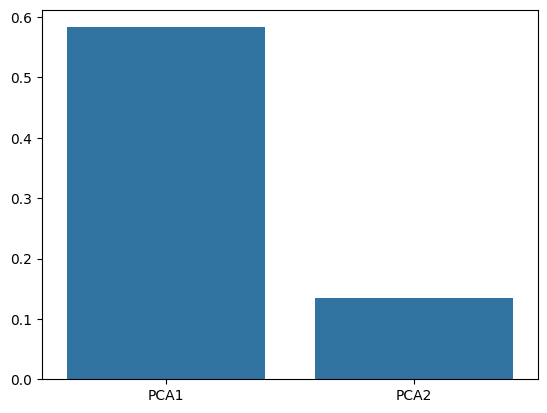

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x=['PCA1','PCA2'],y=pca2.explained_variance_ratio_)

 la instrucción sns.scatterplot(x='PCA1',y='PCA2',hue='MEDV',data=df_2)
 crea un gráfico de dispersión que visualiza la distribución de las muestras en el espacio bidimensional definido por las dos primeras componentes principales (PCA1 y PCA2). El color de cada punto en el gráfico indica el valor de la variable 'MEDV', lo que permite explorar posibles relaciones o patrones entre las componentes principales y la variable objetivo. Este tipo de visualización es útil para comprender la estructura de los datos después de la reducción de dimensionalidad mediante PCA y su relación con la variable objetivo.

<Axes: xlabel='PCA1', ylabel='PCA2'>

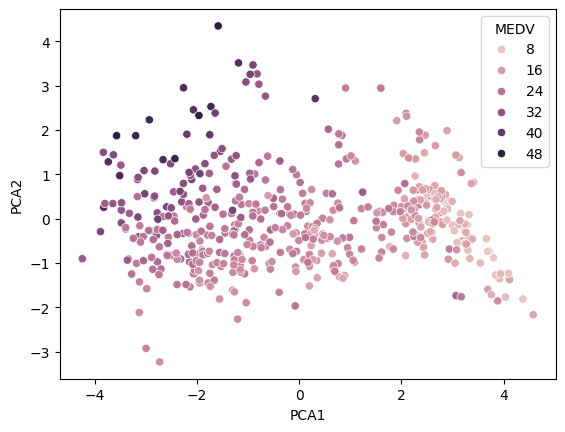

In [36]:
sns.scatterplot(x='PCA1',y='PCA2',hue='MEDV',data=df_2)

Esta instrucción crea un array de puntos (o "bines") equidistantes entre 0 y 25, dividiendo ese intervalo en 50 partes iguales. Aquí está la explicación detallada:

np.linspace(0, 50, 50): Esta es una función de la biblioteca NumPy que genera un array de números equidistantes en un intervalo específico. En este caso, se está generando un array de 50 números entre 0 y 25 (ambos incluidos).

0: Es el punto de inicio del intervalo.
50: Es el punto final del intervalo.
50: Especifica la cantidad total de puntos a generar.
bins: Esta variable almacena el array de puntos generado por np.linspace.

print("bins:{}".format(bins)): Esta instrucción imprime en la consola el contenido de la variable bins. El formato utilizado es una cadena de texto que incluye el valor de bins en el lugar designado por {}.

In [48]:
bins = np.linspace(0,50,50)
print("bins:{}".format(bins))

bins:[ 0.          1.02040816  2.04081633  3.06122449  4.08163265  5.10204082
  6.12244898  7.14285714  8.16326531  9.18367347 10.20408163 11.2244898
 12.24489796 13.26530612 14.28571429 15.30612245 16.32653061 17.34693878
 18.36734694 19.3877551  20.40816327 21.42857143 22.44897959 23.46938776
 24.48979592 25.51020408 26.53061224 27.55102041 28.57142857 29.59183673
 30.6122449  31.63265306 32.65306122 33.67346939 34.69387755 35.71428571
 36.73469388 37.75510204 38.7755102  39.79591837 40.81632653 41.83673469
 42.85714286 43.87755102 44.89795918 45.91836735 46.93877551 47.95918367
 48.97959184 50.        ]


Este código utiliza la biblioteca scikit-learn en Python para implementar una regresión polinómica regularizada (Ridge) mediante la creación de un modelo de pipeline. Aquí está el desglose del código:

Importación de bibliotecas:

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

make_pipeline: Función para crear un pipeline de procesamiento de datos y modelo de manera más concisa.
PolynomialFeatures: Clase que genera características polinómicas para una regresión polinómica.

El bucle itera sobre diferentes grados de polinomios (desde 2 hasta 5). En cada iteración, se crea un modelo de regresión polinómica de Ridge utilizando make_pipeline con PolynomialFeatures y linear_model.Ridge(). Luego, se evalúa el rendimiento del modelo utilizando validación cruzada (cross_val_score), y se imprime el error cuadrático medio (MSE) medio y la desviación estándar de los errores cuadráticos medios.

Creación y evaluación de un modelo específico:

model = make_pipeline(PolynomialFeatures(degree=2), linear_model.Ridge())
scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['PolyRidge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Se crea un modelo de regresión polinómica de Ridge con un grado polinómico de 2 utilizando make_pipeline y PolynomialFeatures(degree=2).
Se evalúa el rendimiento del modelo utilizando validación cruzada (cross_val_score) con el conjunto de datos x_scaled y y.
Los resultados se almacenan en un diccionario llamado scores_map con la clave 'PolyRidge'.
Se imprime el MSE medio y la desviación estándar de los MSE obtenidos durante la validación cruzada.

En resumen, este código explora y evalúa modelos de regresión polinómica de Ridge con diferentes grados polinómicos, aunque solo se muestra la implementación y evaluación para un grado polinómico específico (2)

In [49]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

model = make_pipeline(PolynomialFeatures(degree=2), linear_model.Ridge())
scores = cross_val_score(model, x_scaled, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['PolyRidge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -0.03 (+/- 0.03)


El grado 2 tienen un mejor desempeño

¿Qué estrategia de ingeniería de características ofrece los mejores resultados y por qué?

La ingeniería de características implica la extracción y transformación de variables a partir de datos sin procesar, considero que utilizar Principal Component Analysis (PCA)  como una técnica de reducción de dimensionalidad nos ayuda a reducir la complejidad de conjuntos de datos que tienen muchas características (o variables) al identificar las direcciones en las que los datos varían más. Al proyectar los datos en un nuevo conjunto de ejes (llamados componentes principales), PCA ayuda a resumir la información esencial del conjunto de datos en menos dimensiones.

PCA es "bueno" en varios casos debido a sus beneficios:

Reducción de dimensionalidad: PCA permite representar los datos en un espacio de dimensiones más bajas mientras se conserva la mayor cantidad posible de variabilidad en los datos originales. Esto es útil para conjuntos de datos grandes y complejos.

Eliminación de la multicolinealidad: En conjuntos de datos con variables altamente correlacionadas, PCA puede ayudar a reducir la multicolinealidad al expresar la misma información en términos de componentes principales no correlacionados.

Mejora de la eficiencia computacional: Al reducir la dimensionalidad, los cálculos posteriores en el conjunto de datos se vuelven más eficientes y menos propensos a problemas como el sobreajuste.

Visualización: PCA se puede utilizar para visualizar datos en dos o tres dimensiones, lo que facilita la interpretación y comprensión de la estructura subyacente en los datos.

Sin embargo, PCA no siempre es la mejor opción. Hay situaciones en las que otras técnicas de reducción de dimensionalidad o modelos más complejos pueden ser más apropiados, dependiendo de la naturaleza específica de los datos y los objetivos del análisis. Además, PCA asume que la variabilidad en los datos se correlaciona con su importancia, lo cual puede no ser siempre el caso.

En resumen, PCA es una herramienta valiosa en el kit de herramientas de análisis de datos, pero su idoneidad depende del contexto y de los objetivos específicos de la tarea en cuestión.